In [1]:
import pandas as pd
import numpy as np
import wikipedia # Wikipedia is a Python library that makes it easy to access and parse data from Wikipedia
import geopandas as gpd
import requests
import shapely
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans # import k-means for clustering 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import json
from geopandas import GeoDataFrame
import sys

# Create a pandas dataframe including the boroughs, and their including neighbourhoods, for the city of Munich, Germany

## Collect the required data from a wikipedia page

In [2]:
wikipedia.set_lang('de') # we need to change the language since the page is in german

In [3]:
wiki_munich=wikipedia.page("Liste der Stadtteile Münchens")

In [4]:
df_boroughs = pd.read_html(wiki_munich.url, header =0)[1] # we want to get the data from the second table on the page and use the first row as header
df_boroughs.head(2)

,Stadtteil,"Stadtbezirk, in dem der Stadtteil (größtenteils) liegt",Stadt-bezirks-nr.,Quartiere und Siedlungen im Stadtteil
0,Allach,Allach-Untermenzing,23,"Allach, Gerberau"
1,Altstadt,Altstadt-Lehel,1,"Angerviertel, Graggenauviertel, Hackenviertel,..."


In [5]:
df_boroughs.columns=['Neighbourhood', 'Borough', 'Borough #', 'Drop'] #rename the columns
df_boroughs=df_boroughs.drop(columns='Drop')# drop the 4th column
df_boroughs.head(2)

,Neighbourhood,Borough,Borough #
0,Allach,Allach-Untermenzing,23
1,Altstadt,Altstadt-Lehel,1


## Group the Neighbourhoods by the Boroughs and join them into one row

In [6]:
df_boroughs=df_boroughs.groupby(['Borough', 'Borough #'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).reset_index()

In [7]:
df_boroughs.head(2)

,Borough,Borough #,Neighbourhood
0,Allach-Untermenzing,23,"Allach, Untermenzing"
1,Altstadt-Lehel,1,"Altstadt, Lehel"


In [8]:
df_b2=df_boroughs.copy() #will be used later

## In order to get geodata for the Boroughs we use https://geoconverter.hsr.ch to convert a WFS from https://www.opengov-muenchen.de/dataset/verwaltungseinheiten-der-landeshauptstadt-muenchen into a .shp file. Then we import that file and add the geometry data to df_boroughs, for that we order df_boroughs in alphabetical order and concat the column from df_bg.

In [9]:
fname='/Users/achimpeichl/Downloads/4293d9ed-3d60-4db1-ac58-8cb6998dd3a8/converted.shp/ms:bgl0.shp'

In [10]:
df_bg=gpd.read_file(fname)

In [11]:
df_bg.head(2)

,gml_id,X,Y,SB_NUMMER,NAME,FLAECHE_QM,SHAPE_AREA,SHAPE_LEN,geometry
0,None,4472560.100000,5332114.700000,14,Berg am Laim,6314554.17067163,0.00000000000e+000,0.00000000000e+000,"POLYGON ((11.64551067005214 48.13598140892672,..."
1,None,4469603.810000,5329427.850000,17,Obergiesing-Fasangarten,5720359.98324519,0.00000000000e+000,0.00000000000e+000,"POLYGON ((11.5980388917605 48.12258581610786, ..."


In [12]:
df_bg.X=df_bg.geometry.centroid.x
df_bg.Y=df_bg.geometry.centroid.y

In [13]:
df_bg.sort_values(by=['NAME'], inplace=True)
df_bg=df_bg.reset_index(drop=True)

In [14]:
df_boroughs = pd.concat([df_boroughs, df_bg['geometry'],df_bg['X'],df_bg['Y']], axis=1, join_axes=[df_boroughs.index])

In [15]:
df_boroughs.head(2)

,Borough,Borough #,Neighbourhood,geometry,X,Y
0,Allach-Untermenzing,23,"Allach, Untermenzing","POLYGON ((11.48329263963453 48.21397134072757,...",11.463320,48.193009
1,Altstadt-Lehel,1,"Altstadt, Lehel","POLYGON ((11.5912714239473 48.15649092777394, ...",11.582557,48.141083


# Collect data on the rents and housing quality/ living conditions in each of the Boroughs/Neighbourhoods

![title](https://suedbayerische-immobilien.de/sites/default/files/Wohnqualitaet-Muenchen-Toplagen/Wohnqualitaet-Muenchen-Wohnviertel-Toplagen-Stadtteile.png)


## I have used the above image to rate the locations from 1 (worst) to 4 (best) and the written the data into a csv file. We will now import that file and create a pandas dataframe

In [16]:
quality='/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/quality_of_living.csv'
df_quality=pd.read_csv(quality, sep=';')  # quality of living
df_quality.head(3)

,Borough #,Quality of Living (4=best)
0,1,4
1,2,4
2,3,4


## Retrieve the Zip Codes and add them to the dataframe

In [17]:
url_zip = 'https://www.muenchen.de/leben/service/postleitzahlen.html'

In [18]:
df_zip = pd.read_html(url_zip, header =0)[0]
df_zip.rename({'Stadtteil':'Borough', 'Postleitzahl': 'ZIP'}, axis='columns', inplace=True)
df_zip.head(2)

,Borough,ZIP
0,Allach-Untermenzing,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,"80331, 80333, 80335, 80336, 80469, 80538, 80539"


#### Since the Names ob the Boroughs are in alphabetical order we can just concat the ZIP column from df_zip to  df_boroughs.

In [19]:
df_muc = pd.concat([df_boroughs, df_zip['ZIP']], axis=1, join_axes=[df_boroughs.index])

In [20]:
df_muc.head(2)

,Borough,Borough #,Neighbourhood,geometry,X,Y,ZIP
0,Allach-Untermenzing,23,"Allach, Untermenzing","POLYGON ((11.48329263963453 48.21397134072757,...",11.463320,48.193009,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,1,"Altstadt, Lehel","POLYGON ((11.5912714239473 48.15649092777394, ...",11.582557,48.141083,"80331, 80333, 80335, 80336, 80469, 80538, 80539"


## Next we will collect rent data for the Neighbourhoods

In [21]:
url_rent='https://www.miet-check.de/mietpreise/plz/muenchen/6562/'

In [22]:
df_rent=pd.read_html(url_rent, header=0)[0]
df_rent.head(2)

,#,PLZ,Mietpreis pro m2,Anzahl Einträge,Informationen
0,1,80331,23.2 Euro,178,mehr Infos
1,2,80333,22.9 Euro,244,mehr Infos


#### We only need the columns "PLZ"-->"ZIP" and "Mietpreis pro m2"-->"rpm2" (rpm2 = rent per m2)

In [23]:
df_rent=df_rent.drop(columns= ['#', 'Anzahl Einträge', 'Informationen'])

In [24]:
df_rent.columns=['ZIP', 'rpm2']

#### Remove the Euro

In [25]:
df_rent['rpm2'] = df_rent['rpm2'].map(lambda x: str(x)[:-5])

## Now we will need to add the rent data to the existing data

### Since the rent data does not match the bouroughs nor the neighbourhoods exactly we will have to join the data using the ZIP codes. To achieve this we will first create a dictionary out of df_rent (with the ZIP code as the key) and then use that dictonary to replace the ZIP code values in  df_zip with the rpm2 values for the corresponding ZIP code. At the end we will calculate the mean/average rent for each Borough.

#### Create the dictonary

In [26]:
rdic=dict(zip(df_rent.ZIP,df_rent.rpm2))

#### Replace the Zip codes in df_zip  with the rpm2 values

In [27]:
df_zip.head(2)

,Borough,ZIP
0,Allach-Untermenzing,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,"80331, 80333, 80335, 80336, 80469, 80538, 80539"


##### First we need to split up the ZIP code column into one  ZIP code per column

In [28]:
z=df_zip

In [29]:
z=pd.concat([z[['Borough']], z['ZIP'].str.split(',', expand=True)], axis=1)

In [30]:
z.set_index('Borough', inplace=True)
z.head(1)

,0,1,2,3,4,5,6,7,8
Borough,,,,,,,,,
Allach-Untermenzing,80995,80997,80999,81247,81249,None,None,None,None


In [31]:
z.head(10)

,0,1,2,3,4,5,6,7,8
Borough,,,,,,,,,
Allach-Untermenzing,80995,80997,80999,81247,81249,None,None,None,None
Altstadt-Lehel,80331,80333,80335,80336,80469,80538,80539,None,None
Au-Haidhausen,81541,81543,81667,81669,81671,81675,81677,None,None
Aubing-Lochhausen-Langwied,81243,81245,81249,None,None,None,None,None,None
Berg am Laim,81671,81673,81735,81825,None,None,None,None,None
Bogenhausen,81675,81677,81679,81925,81927,81929,None,None,None
Feldmoching-Hasenbergl,80933,80935,80995,None,None,None,None,None,None
Hadern,80689,81375,81377,None,None,None,None,None,None
Laim,80686,80687,80689,None,None,None,None,None,None


In [32]:
df_zip=z

##### Then we can replace the values

In [33]:
df_zip = df_zip.apply(pd.to_numeric)

In [34]:
df_zip.replace(rdic, inplace=True)
df_zip.head(1)

,0,1,2,3,4,5,6,7,8
Borough,,,,,,,,,
Allach-Untermenzing,15.95,16.95,15.56,17.29,16.11,NaN,NaN,NaN,NaN


##### Next we will calculate the average rent per Borough (we will need to convert the df to numeric values before we can calculate the average)

In [35]:
df_zip=df_zip.apply(pd.to_numeric)

In [36]:
df_zip['average rent'] = df_zip.mean(numeric_only=True, axis=1)
df_zip.head(1)

,0,1,2,3,4,5,6,7,8,average rent
Borough,,,,,,,,,,
Allach-Untermenzing,15.95,16.95,15.56,17.29,16.11,NaN,NaN,NaN,NaN,16.372


In [37]:
rent=df_zip[['average rent']]

In [38]:
rent.reset_index(inplace=True)
rent.sample(3)

,Borough,average rent
24,Untergiesing-Harlaching,18.723333
18,Schwabing-West,22.227500
8,Laim,17.473333


# Miete mit der Wohnqualität vergleichen (daten zum DF hinzufügen und dann nach Mieten (absteigend) ordnen. Korrelation zu Wohnqualität gegeben?

## In the next step we will collect data from foursquare and use that data for clustering

#### Foursquare credentials

In [39]:
CLIENT_ID = '0MJA3NYYG3U2ZY1LTZN2OYEHS3Y3WVSON2GBSO3IL4EDYVIR' # your Foursquare ID
CLIENT_SECRET = 'WGWSAF2TKVUQPE3PD0N3EOITFVBY5EYP1VCZI3BMUG0ROUS5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Import geodata from https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/table/ using geopandas

In [40]:
fname='/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/muc.geojson'
df_geo=gpd.read_file(fname)

#### Get the latitude/y and longitude/x of the centroid for each polygon/ZIP

In [41]:
df_geo['latitude']=df_geo['geometry'].centroid.y
df_geo['longitude']=df_geo['geometry'].centroid.x
df_geo['point']=df_geo['geometry'].centroid

In [42]:
df_geo.head(2)

,note,plz,geometry,latitude,longitude,point
0,München,80997,"POLYGON ((11.4597967 48.2117073, 11.460079 48....",48.191879,11.482502,POINT (11.48250248003875 48.19187885565856)
1,München,81669,"POLYGON ((11.5825324 48.1269235, 11.5837205 48...",48.120075,11.601146,POINT (11.60114591581964 48.12007527984551)


In [43]:
df_lalo=df_geo[['plz','latitude','longitude']]

### Collect the Data from foursquare

In [44]:
def getNearbyVenues(latitudes, longitudes):
    radius=1150
    LIMIT=500
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
df_venues_ = getNearbyVenues(latitudes=df_lalo['latitude'], longitudes=df_lalo['longitude'])

In [47]:
df_venues = df_venues_.copy()

In [48]:
df_venues.sample(2)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1596,48.139105,11.602731,Chuchin,48.142590,11.601262,Vietnamese Restaurant
1045,48.114224,11.547808,Schinderstadl,48.107361,11.552488,BBQ Joint


### Since not every Venue has a ZIP code in it's description we need to find another way to assign a ZIP code to each venue. To achieve this we use geopandas and shapley. First we use the longitude and latitude values of each venue to create a POINT. The df_geo dataframe contains a POLYGON that describes the boundaries for each ZIP code. This allows us then to check for each POLYGON (in the df_geo dataframe) if any of the POINTS in  df_venues is within that POLYGON. If True we then  write the correspondending ZIP code into a new column 'ZIP' in df_venues.

In [49]:
df_venues = gpd.GeoDataFrame(
    df_venues, geometry=gpd.points_from_xy(df_venues['Venue Longitude'], df_venues['Venue Latitude']))

In [50]:
df_venues.sample(2)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry
410,48.162916,11.570052,Taverna Lakis,48.154680,11.566709,Taverna,POINT (11.56670921707967 48.15468047176395)
1787,48.145276,11.436811,SUBWAY,48.142801,11.423451,Sandwich Place,POINT (11.42345126624638 48.14280133262172)


In [51]:
x=0
for row in df_geo.iterrows():
    df_venues.loc[df_venues.geometry.within(df_geo.geometry[x]), 'ZIP'] = df_geo.plz[x]
    x=x+1

In [52]:
temp=df_venues.ZIP.isnull()


## Now the same for bouroughs from df_muc

In [53]:
x=0
for row in df_boroughs.iterrows():
    df_venues.loc[df_venues.geometry.within(df_boroughs.geometry[x]), 'Borough'] = df_boroughs['Borough'][x]
    x=x+1

In [54]:
df_venues.sample(2)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry,ZIP,Borough
1081,48.114224,11.547808,Franziska-Reindl-Platz / Thalkirchen,48.104960,11.547471,Plaza,POINT (11.54747114334283 48.10495973683842),81379,Thalkirchen-Obersendling-Forstenried-Fürstenri...
2350,48.138518,11.631207,H Baumkirchner Straße,48.128443,11.630258,Tram Station,POINT (11.63025847038271 48.12844280598829),81673,Berg am Laim


#### Since we did a search by radius we will have duplicates in the dataframe (some venues might be within the radius from more than one ZIP centroid). Right now df_venues.drop_duplicates() will not eliminated those duplicates since they differ in the 'Neighborhood Latitude/Longitude' columns ('geometry' is also dropped since it creates problems performin .drop_duplicates ). So we can drop those columns and then use .drop_duplicates

In [55]:
df_venues.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'geometry'], inplace=True)

In [56]:
df_venues.drop_duplicates(inplace=True)

In [57]:
df_venues.shape

(2912, 6)

In [58]:
#df_venues.groupby('Borough').count()

# Consolidate all important data into one df

In [59]:
df_muc['latitude']=df_muc['Y']
df_muc['longitude']=df_muc['X']

In [60]:
df_munich=df_muc.drop(columns='geometry')

In [61]:
df_munich = df_munich.join(rent.set_index('Borough'), on='Borough')

In [62]:
df_munich.head(1)

,Borough,Borough #,Neighbourhood,X,Y,ZIP,latitude,longitude,average rent
0,Allach-Untermenzing,23,"Allach, Untermenzing",11.46332,48.193009,"80995, 80997, 80999, 81247, 81249",48.193009,11.46332,16.372


# Now lets analyze the Boroughs

In [63]:
# one hot encoding
muc_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
muc_onehot['Borough'] = df_venues['Borough'] 

# move neighborhood column to the first column
cols=list(muc_onehot.columns.values)
cols.pop(cols.index('Borough'))
muc_onehot=muc_onehot[['Borough']+cols]

muc_onehot.head(3)

,Borough,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [64]:
muc_grouped = muc_onehot.groupby('Borough').mean().reset_index()
muc_grouped.shape

(25, 294)

## Cluster Neighbourhoods

#### Run k-means to cluster the neighbourhood into 5 clusters.

### Determine the best k with the elbow-method

In [65]:
muc_grouped_clustering = muc_grouped.drop('Borough', 1)

In [66]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(muc_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

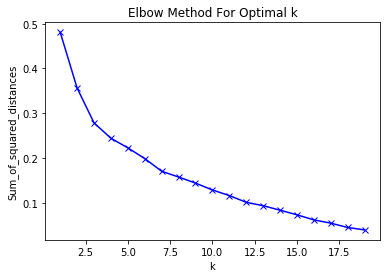

In [67]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [68]:
# set number of clusters
kclusters = 4


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(muc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 1, 3, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0], dtype=int32)

In [69]:
labels_venues=kmeans.labels_ # save the labels for later use

#### Let's create a new dataframe that includes the cluster labels

In [70]:
muc_merged = df_munich

# add clustering labels
muc_merged['Cluster Labels'] = kmeans.labels_

In [71]:
muc_merged.sample(3)

,Borough,Borough #,Neighbourhood,X,Y,ZIP,latitude,longitude,average rent,Cluster Labels
1,Altstadt-Lehel,1,"Altstadt, Lehel",11.582557,48.141083,"80331, 80333, 80335, 80336, 80469, 80538, 80539",48.141083,11.582557,22.350000,1
10,Maxvorstadt,3,Maxvorstadt,11.564687,48.148558,"80333, 80335, 80539, 80636, 80797, 80798, 8079...",48.148558,11.564687,22.507778,1
4,Berg am Laim,14,Berg am Laim,11.632368,48.126861,"81671, 81673, 81735, 81825",48.126861,11.632368,16.562500,0


# Clusters visualization - Munich Boroughs

### Let's create a map of Munich showing the clusters and average rent

In [72]:
# Latitude and longitude for Munich:
latitude=48.137154
longitude=11.576124

#### Create a choropleth map using the shapefile for the Boroughs and the rent data

In [73]:
df_choro=pd.concat([df_munich[['Borough', 'average rent']], df_muc['geometry']], axis=1)

In [74]:
gdf_choro=GeoDataFrame(df_choro) #convert df_choro to a geodataframe

In [75]:
gdf_choro.head(2)

,Borough,average rent,geometry
0,Allach-Untermenzing,16.372,"POLYGON ((11.48329263963453 48.21397134072757,..."
1,Altstadt-Lehel,22.350,"POLYGON ((11.5912714239473 48.15649092777394, ..."


In [76]:
gdf_choro.to_file('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/choro.geojson',driver='GeoJSON')
#write the geodataframe to a geojson file

In [77]:
bezirke = '/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/choro.geojson'

In [78]:
# Latitude and longitude for Munich:
latitude=48.137154
longitude=11.576124
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
#create a choropleth layer displaying the average rent
map_clusters.choropleth(
    geo_data=bezirke,
    name='choropleth',
    data=gdf_choro,
    columns=['Borough', 'average rent'],
    key_on='feature.properties.Borough',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='average rent'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(muc_merged['latitude'], muc_merged['longitude'], muc_merged['Borough'], muc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)


#display the map
map_clusters

# Use ZIP instead of Borough

## Start by analyzing by ZIP codes

In [79]:
# one hot encoding
muc2_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
muc2_onehot['ZIP'] = df_venues['ZIP'] 

# move neighborhood column to the first column
cols=list(muc2_onehot.columns.values)
cols.pop(cols.index('ZIP'))
muc2_onehot=muc2_onehot[['ZIP']+cols]

muc2_onehot.head(1)

,ZIP,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,80997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
muc2_onehot.shape

(2912, 294)

In [81]:
# group rows by ZIP and by taking the mean of the frequency of occurrence of each category
muc2_grouped = muc2_onehot.groupby('ZIP').mean().reset_index()

In [82]:
muc2_grouped.shape

(74, 294)

## Cluster the ZIP codes

In [83]:
muc2_grouped_clustering = muc2_grouped.drop('ZIP', 1)

In [84]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(muc2_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

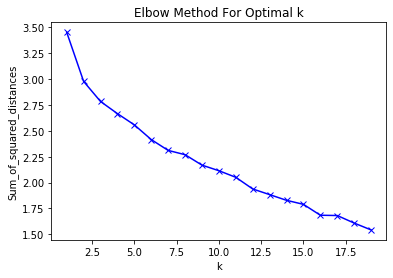

In [85]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [86]:
# set number of clusters
kclusters = 7



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(muc2_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 2, 6, 6, 5, 5, 5, 5, 2, 2, 5, 5, 0, 5, 4, 0, 0, 5, 2, 5, 5, 5,
       2, 2, 6, 0, 6, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 6, 0, 3, 0, 5,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 4, 0, 0, 5, 2, 0, 0, 5, 0, 2, 1,
       0, 6, 1, 0, 6, 0, 1, 6], dtype=int32)

In [87]:
df_geozip=gpd.read_file(fname)
#remove the duplicates, since drop duplicates does not work with POLYGONS we need to use a workaround
df_temp=df_geozip[['plz']]
df_temp.drop_duplicates(inplace=True)
df_temp.join(df_geozip.geometry)
df_geozip=df_temp

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [88]:
df_geozip['Cluster Labels'] = kmeans.labels_

# Clusters visualization - Munich ZIP


In [89]:
df_geo['plz']=df_geo['plz'].astype(int) #need to convert str to int so pd.merge will work 
#df_choro2=pd.merge(df_rent, df_geo, left_on='ZIP', right_on='plz')
df_geo.drop(columns=['note', 'point'], inplace=True)

In [90]:
df_choro2=df_rent.apply(pd.to_numeric)

In [91]:
gdf_geo=GeoDataFrame(df_geo) #convert df_geo into a geodataframe (in order to create a geojson for the ZIP overlay)

In [92]:
gdf_geo.head()

,plz,geometry,latitude,longitude
0,80997,"POLYGON ((11.4597967 48.2117073, 11.460079 48....",48.191879,11.482502
1,81669,"POLYGON ((11.5825324 48.1269235, 11.5837205 48...",48.120075,11.601146
2,80686,"POLYGON ((11.490444 48.1377022, 11.4907062 48....",48.132127,11.512238
3,80802,"POLYGON ((11.579715 48.15565839999999, 11.5798...",48.159255,11.591139
4,80331,"POLYGON ((11.5631981 48.13660969999999, 11.563...",48.135964,11.572905


In [93]:
gdf_geo.to_file('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/choro2.geojson',driver='GeoJSON')
#write the geodataframe to a geojson file

In [94]:
plz = r'/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/choro2.geojson'

In [95]:
df_lalo2=df_lalo.copy()

In [96]:
rdic2=dict(zip(df_geozip.plz,df_geozip['Cluster Labels']))

In [97]:
df_lalo2.replace(rdic2, inplace=True)

In [98]:
df_lalo2.head()

,plz,latitude,longitude
0,5,48.191879,11.482502
1,2,48.120075,11.601146
2,6,48.132127,11.512238
3,6,48.159255,11.591139
4,5,48.135964,11.572905


In [99]:
df_lalo[['Cluster Labels']]=df_lalo2[['plz']]

In [100]:
# Latitude and longitude for Munich:
latitude=48.137154
longitude=11.576124
# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
#create a choropleth layer displaying the average rent
map_clusters2.choropleth(
    geo_data=plz,
    name='choropleth',
    data=df_choro2,
    columns=['ZIP', 'rpm2'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='rpm2'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_lalo['latitude'], df_lalo['longitude'], df_lalo['plz'], df_lalo['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters2)

folium.LayerControl().add_to(map_clusters2)


#display the map
map_clusters2

# Import weiterer statistischer Daten

### Crime

In [101]:
df_crime=pd.read_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/offences2017.csv', sep=';')

In [102]:
df_crime.head(1)

,Borough,Offences (overall)
0,1,7868


## Function to read and clean the csv Data

In [103]:
def readclean_csv(path, characteristic='gesamt'):
    dataframe=pd.read_csv(path) #read the csv into a pandas dataframe
    dataframe=dataframe[dataframe['Jahr']==dataframe['Jahr'].max()] #select the data for the most recent year
    dataframe=dataframe.loc[dataframe['Räumliche Gliederung']!='Stadt München'] #only get the data for the boroughs
    #get the borough numbers from the string and then convert it to an integer
    dataframe['Räumliche Gliederung']=dataframe['Räumliche Gliederung'].map(lambda x: str(x)[:2])
    dataframe['Räumliche Gliederung']=pd.to_numeric(dataframe['Räumliche Gliederung'])
    dataframe=dataframe[dataframe['Ausprägung']==characteristic] # filter for the desired characteristic
    dataframe.drop(dataframe.columns[drop_columns], axis=1, inplace=True)# drop columns that are not important
    dataframe.reset_index(drop=True, inplace=True)# the index of all dataframes is supposed to start with 0
    # create a dataframe with the consolidated (usefull) data off all the processed csv files
    df_allcsv[dataframe.iat[0,0]]=dataframe['Indikatorwert'] # add a new column named after the charactereistic/indicator of the dataframe and fill the column with the indicator value

    return dataframe

#### initialize a dataframe for the consolidated data from the csv files

In [104]:
df_allcsv=pd.DataFrame()
df_allcsv['Offences (overall)']=df_crime['Offences (overall)'] # add the data from df_crime

### Labor/Employment

In [105]:
drop_columns=[1,2,5,6,7,8]

#### unemployment rate

In [106]:
df_unempl=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/arbeit-arbeitsmarktarbeitslosendichte.csv')

In [107]:
df_unempl.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Arbeitslosendichte,1,2.1


#### employment subject to social insurance contributions

In [108]:
df_socialempl=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/arbeit-arbeitsmarktsozialversicherungspflichtigbeschaeftigtendichte.csv') 

In [109]:
df_socialempl.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Sozialversicherungspflichtig Beschäftigtendichte,1,53.1


In [110]:
df_alg=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/arbeit-arbeitsmarktalgii-empfaengerdichteerwerbsfaehigeregelleistungsberechtigtendi.csv') # unemployment benefit rate

In [111]:
df_alg.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,ALG II-Empfängerdichte_Erwerbsfähige Regelleis...,1,2.0


### Population

In [112]:
drop_columns=[1,2,5,6,7,8,9,10,11,12,13,14]

#### percentage with migration background

In [113]:
df_migration=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungmigrationshintergrundquote.csv', characteristic='Deutsche und Ausländer gesamt') #percentage with migration background

In [114]:
df_migration.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Migrationshintergrundquote,1,38.3


#### percentage foreign population (part of the above number too)

In [115]:
df_foreignpop=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungauslaenderinnenanteil.csv')

In [116]:
df_foreignpop.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Ausländer_innenanteil,1,26.2


#### population density (popultaion per square kilometer)

In [117]:
df_popdensity=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungeinwohnerdichte.csv', characteristic='Wert')

In [118]:
df_popdensity.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Einwohnerdichte,1,6652


#### one-person household percentage

In [119]:
df_onepers=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungeinpersonenhaushalte.csv', characteristic='Haushalte - gesamt')

In [120]:
df_onepers.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Einpersonenhaushalte,1,64.8


#### average age

In [121]:
df_avgage=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungaltersdurchschnitt.csv')

In [122]:
df_avgage.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Altersdurchschnitt,1,41.7


#### fertility rate

In [123]:
df_fertility=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerungallgemeinegeburtenrate.csv')

In [124]:
df_fertility.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Allgemeine Geburtenrate,1,47.1


In [125]:
df_fertility.reset_index(drop=True, inplace=True)

#### percentage of households with children

In [126]:
df_children=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bevoelkerunghaushaltemitkindern.csv', characteristic='Haushalte mit Kindern - gesamt')

In [127]:
df_children.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Haushalte mit Kindern,1,12.0


### Education

In [128]:
drop_columns=[1,2,5,6,7,8]

#### non native speaking students elementary school

In [129]:
df_nnelementary=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/bildung-grundschuelerfamiliensprache-nichtdeutsch.csv', characteristic='Wert')

In [130]:
df_nnelementary.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Familiensprache-nicht deutsch,1,26.4


### Healthcare

#### doctors density

In [131]:
df_doctors=readclean_csv('/Users/achimpeichl/Documents/GitHub/Coursera_Capstone/Munich/data/gesundheit-aerztedichte.csv', characteristic='alle Ärzte (ohne Therapeuten)')

In [132]:
df_doctors.head(1)

,Indikator,Räumliche Gliederung,Indikatorwert
0,Ärztedichte,1,34.9


## Normalize the data in df_allcsv

In [133]:
df_datanormal1 = (df_allcsv - df_allcsv.mean())/df_allcsv.std() # Standard score

In [134]:
df_datanormal1.head(3)

,Offences (overall),Arbeitslosendichte,Sozialversicherungspflichtig Beschäftigtendichte,ALG II-Empfängerdichte_Erwerbsfähige Regelleistungsberechtigtendichte,Migrationshintergrundquote,Ausländer_innenanteil,Einwohnerdichte,Einpersonenhaushalte,Altersdurchschnitt,Allgemeine Geburtenrate,Haushalte mit Kindern,Familiensprache-nicht deutsch,Ärztedichte
0,1.990058,-1.865600,-2.360344,-1.831007,-0.724736,-0.321419,-0.142431,1.337314,0.444522,-0.869886,-1.368504,-1.369351,-1.500843
1,3.692798,-0.605059,-0.957465,-0.865286,-0.414041,0.255842,1.099854,1.324084,-1.542581,-1.430992,-1.230439,-0.922510,-1.128463
2,0.461041,-1.305360,0.094694,-1.573481,-0.806498,-0.529233,1.150729,1.879754,-1.836967,-1.737051,-1.948378,-0.778368,-1.091301


In [135]:
df_datanormal2 = (df_allcsv-df_allcsv.min())/(df_allcsv.max()-df_allcsv.min())*5 # Min-Max Feature scaling (from 0-5

In [136]:
df_datanormal2.head(3)

,Offences (overall),Arbeitslosendichte,Sozialversicherungspflichtig Beschäftigtendichte,ALG II-Empfängerdichte_Erwerbsfähige Regelleistungsberechtigtendichte,Migrationshintergrundquote,Ausländer_innenanteil,Einwohnerdichte,Einpersonenhaushalte,Altersdurchschnitt,Allgemeine Geburtenrate,Haushalte mit Kindern,Familiensprache-nicht deutsch,Ärztedichte
0,3.192881,0.0,0.000000,0.000000,0.518672,1.039326,1.851722,4.259928,3.369565,1.133333,0.652174,0.000000,0.000000
1,5.000000,1.8,1.684211,1.363636,0.912863,1.741573,3.629586,4.241877,0.434783,0.400000,0.807453,0.595010,0.501130
2,1.570135,0.8,2.947368,0.363636,0.414938,0.786517,3.702394,5.000000,0.000000,0.000000,0.000000,0.786948,0.551141


In [137]:
df_allcsv.set_index([pd.Index(range(1,26))], inplace=True)

In [138]:
csv_clustering=df_datanormal1

In [139]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(csv_clustering)
    Sum_of_squared_distances.append(km.inertia_)

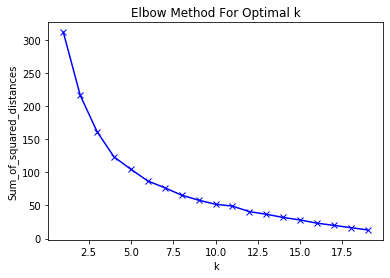

In [140]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [141]:
# set number of clusters
kclusters = 6



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(csv_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 1, 1, 1, 5, 5, 5, 3, 2, 2, 4, 3, 2, 0, 2, 5, 3, 3, 3, 3, 0,
       0, 2, 5], dtype=int32)

In [142]:
#muc_merged = df_munich
#muc_merged.set_index(['Borough #'], inplace=True)# set borough number as index
#muc_merged.sort_index(inplace=True) # sort dataframe by index

In [143]:
# add clustering labels
muc_merged['Cluster Labels'] = kmeans.labels_

# merge muc merged with boroughs_venues_sorted to add latitude/longitude for each neighborhood
#muc_merged = muc_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

In [144]:
muc_merged.head()

,Borough,Borough #,Neighbourhood,X,Y,ZIP,latitude,longitude,average rent,Cluster Labels
0,Allach-Untermenzing,23,"Allach, Untermenzing",11.463320,48.193009,"80995, 80997, 80999, 81247, 81249",48.193009,11.463320,16.372000,4
1,Altstadt-Lehel,1,"Altstadt, Lehel",11.582557,48.141083,"80331, 80333, 80335, 80336, 80469, 80538, 80539",48.141083,11.582557,22.350000,4
2,Au-Haidhausen,5,"Au, Haidhausen",11.595333,48.129815,"81541, 81543, 81667, 81669, 81671, 81675, 81677",48.129815,11.595333,19.818571,1
3,Aubing-Lochhausen-Langwied,22,"Aubing, Freiham, Langwied, Lochhausen",11.409123,48.165481,"81243, 81245, 81249",48.165481,11.409123,16.420000,1
4,Berg am Laim,14,Berg am Laim,11.632368,48.126861,"81671, 81673, 81735, 81825",48.126861,11.632368,16.562500,1


In [145]:
# Latitude and longitude for Munich:
latitude=48.137154
longitude=11.576124
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
#create a choropleth layer displaying the average rent
map_clusters.choropleth(
    geo_data=bezirke,
    name='choropleth',
    data=gdf_choro,
    columns=['Borough', 'average rent'],
    key_on='feature.properties.Borough',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='average rent'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(muc_merged['latitude'], muc_merged['longitude'], muc_merged['Borough'], muc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)


#display the map
map_clusters

#### Add the cluster labels from clustering on the venues data

In [146]:
df_allcsv['Venues']=labels_venues

In [147]:
df_datanormal1v = (df_allcsv - df_allcsv.mean())/df_allcsv.std() # Standard score

In [148]:
csv_clustering=df_datanormal1v

In [149]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(csv_clustering)
    Sum_of_squared_distances.append(km.inertia_)

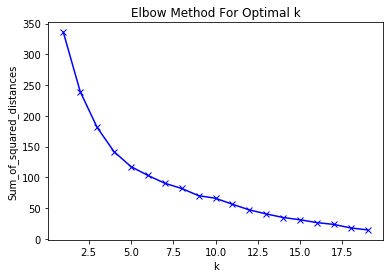

In [150]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [151]:
# set number of clusters
kclusters = 6



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(csv_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 3, 0, 0, 0, 5, 5, 5, 4, 1, 1, 4, 4, 1, 2, 1, 5, 4, 4, 4, 4, 2,
       2, 1, 5], dtype=int32)

In [152]:
# add clustering labels
muc_merged['Cluster Labels'] = kmeans.labels_

In [153]:
df_ql = pd.merge(df_b2, df_quality, how='inner', on = 'Borough #') #add the borough names to the living quality df

In [154]:
df_ql.drop(columns=['Borough #', 'Neighbourhood'], inplace=True) # drop some columns

In [155]:
gdf_choro2=pd.merge(gdf_choro, df_ql, how='inner', on = 'Borough') # merge the ql df with the choropleth df

In [156]:
gdf_choro2['Quality of Living (4=best)']=gdf_choro2['Quality of Living (4=best)'].replace({',':'.'},regex=True).apply(pd.to_numeric,1) # convert the rating from string to float

In [160]:
# Latitude and longitude for Munich:
latitude=48.137154
longitude=11.576124
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
#create a choropleth layer displaying the average rent
map_clusters.choropleth(
    geo_data=bezirke,
    name='Rent',
    data=gdf_choro,
    columns=['Borough', 'average rent'],
    key_on='feature.properties.Borough',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='average rent'
)

#create a choropleth layer displaying the quality of living
map_clusters.choropleth(
    geo_data=bezirke,
    name='Living Quality',
    data=gdf_choro2,
    columns=['Borough', 'Quality of Living (4=best)'],
    key_on='feature.properties.Borough',
    fill_color='Greens',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Living Quality'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(muc_merged['latitude'], muc_merged['longitude'], muc_merged['Borough'], muc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)


#display the map
map_clusters